In [85]:
!pip install transformers accelerate datasets evaluate urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Background

As an AI Development Intern at the CSF, you will be tasked with
developing pipelines.

# Assessment

Please answer the following questions in a jupyter notebook. You should
only spend about two hours on these questions. If you want to spend more
you can. If you\'ve run out of time, please describe thoroughly what
remains to be done and how you would accomplish it.

## Jupyter Notebook to Processing Pipeline

Given a jupyter notebook that has a functioning implementation of a
machine learning model that identifies unique individuals out of a crowd
through gait analysis, how would you translate that notebook to a piece
of software that can be used to apply the model to any arbitrary images
or videos provided.

`Answer:` 
1. I would use the code from the Jupyter notebook to create a python script.
2. I would use this script as a Flask API or Flask app depending on the requirements.
3. If I would use a Flask app then I would design a UI for the app with HTML, CSS and JavaScript.
4. I would deploy the project on a cloud platform so that it could be used directly through a link.

Here is an example of an application that I deployed in Microsoft Azure:
https://jaskiratbot.azurewebsites.net/SmartBot.aspx

I started with a Jupyter notebook, which I converted to a python script to be used in the Flask API. Here is the link to the repository containing the API code: https://github.com/jaskirat-1998/SQUAD

This API is then called by this web application to get the response based on user query. The code for the web application can be found here:https://github.com/jaskirat-1998/JaskiratBot

## Demo

Write a toy implementation of whatever machine learning concept you
would like in order to demonstrate your skills. This doesn\'t need to be
in the notebook if you want to use something other than python.

If you don't have an idea for a concept you would like to show off, here's an idea:

- Create a notebook or application that processes the images it receives from your computer camera.
- Have it classify something. Could be a human, a dog, a pencil, etc.
- Have it identify something specific to the classification. Could be you, your dog, your favorite pencil.

# Submission

Fork this repository and once you\'ve completed the above questions,
create a pull request to merge your fork with the original repository.


# Classifier to distinguish sheep from goats

### Connecting to google drive for data

In [82]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Importing libraries

In [110]:
from transformers import ViTImageProcessor, ViTModel, pipeline
from PIL import Image
import requests
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import urllib3
from transformers import DefaultDataCollator
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoImageProcessor
import evaluate
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix

### Loading the data

In [185]:
train_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Data/sheep_goat", split="train")
test_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Data/sheep_goat", split="test")

Resolving data files:   0%|          | 0/80 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/80 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [186]:
print(train_dataset, test_dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 80
}) Dataset({
    features: ['image', 'label'],
    num_rows: 20
})


In [187]:
labels = ['goat', 'sheep']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### loading a ViT image processor to process the image into a tensor

In [188]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

### Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation

In [191]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size,  scale=(0.8, 1.0)), ToTensor(), normalize])

In [192]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [193]:
train_dataset = train_dataset.with_transform(transforms)
test_dataset = test_dataset.with_transform(transforms)

In [194]:
data_collator = DefaultDataCollator()

In [195]:
accuracy = evaluate.load("accuracy")

In [196]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [197]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [198]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    #per_device_train_batch_size=16,
    #gradient_accumulation_steps=4,
    #per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    #logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [199]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.594354,0.850000
2,No log,0.445796,0.800000
3,No log,0.469651,0.800000
4,No log,0.459802,0.800000
5,No log,0.483535,0.800000


TrainOutput(global_step=50, training_loss=0.29562084197998045, metrics={'train_runtime': 42.7039, 'train_samples_per_second': 9.367, 'train_steps_per_second': 1.171, 'total_flos': 3.09967958458368e+16, 'train_loss': 0.29562084197998045, 'epoch': 5.0})

In [200]:
## Getting the predictions for the evaluation set
pred = [id2label[str(i)] for i in trainer.predict(test_dataset)[0].argmax(1)]
gold = [id2label[str(i['label'])] for i in test_dataset]
print(pred)
print(gold)

['goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'sheep', 'sheep', 'goat', 'sheep', 'sheep', 'goat', 'goat', 'goat', 'sheep', 'sheep']
['goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'goat', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep']


In [201]:
print(classification_report(gold, pred))

              precision    recall  f1-score   support

        goat       0.71      1.00      0.83        10
       sheep       1.00      0.60      0.75        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



### Looking at the above results, all the goats are classified as goats, but some of the sheeps are also classified as goats

#### Let's look at the wrongly classified images

Prediction: goat
Gold: sheep


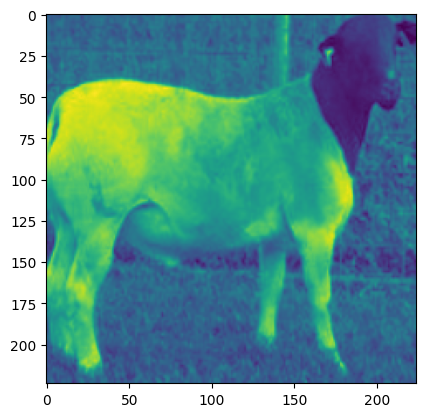

Prediction: goat
Gold: sheep


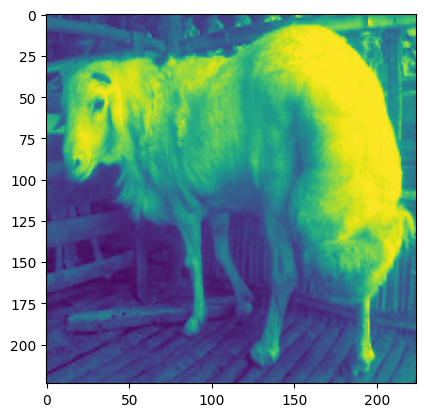

Prediction: goat
Gold: sheep


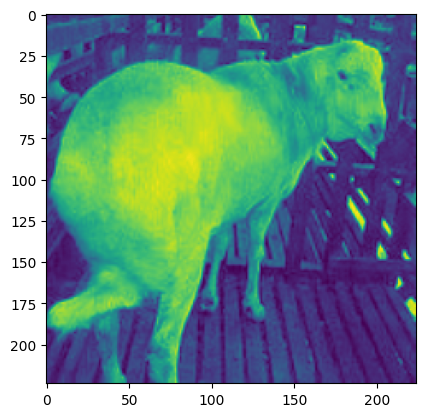

Prediction: goat
Gold: sheep


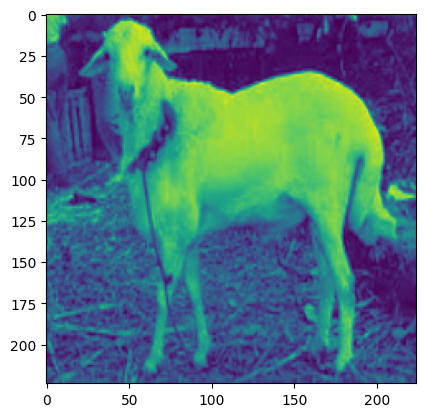

In [202]:
for i in range(len(pred)):
  if pred[i] != gold[i]:
    print(f'Prediction: {pred[i]}')
    print(f'Gold: {gold[i]}')
    plt.imshow(test_dataset[i]['pixel_values'][2])
    plt.show()

## I used a really small dataset for demonstration and we would need more data to build a generalised model, but the model does a decent job and the images which it has wrongly classified (especially first and forth) actually look like goats, but are sheeps 